# Stock Market Trend Analysis using Machine Learning

## AI-Powered Predictive Analytics for Financial Markets


---

## 1. Problem Definition & Objective

### 1.1 Selected Project Track
**Machine Learning - Time Series Prediction & Anomaly Detection with Clustering of similiar tickers**

### 1.2 Problem Statement
Stock market prediction is one of the most challenging problems in financial analytics due to:
- High volatility and non-linear patterns
- Multiple influencing factors (economic indicators, news, sentiment)
- Noise and randomness in price movements

**Core Challenge:** Can we build a AI system that:
1. Predicts short-term stock price trends with reasonable accuracy
2. Detects anomalous price movements that may indicate unusual market behavior
3. Identifies stocks with similar technical patterns for comparative analysis

### 1.3 Real-World Relevance & Motivation

**Why This Matters:**
- **For Investors:** Better informed decision-making with AI-powered insights
- **For Traders:** Early detection of unusual market movements
- **For Analysts:** Pattern recognition across multiple stocks simultaneously
- **For Risk Management:** Identification of potential market anomalies

**Business Impact:**
- Anyone can access institutional-grade analytics
- Risk mitigation through anomaly detection
- Portfolio diversification through similarity analysis
- Educational tool for understanding technical indicators


---

## 2. Data Understanding & Preparation

### 2.1 Dataset Source
**Source:** Yahoo Finance API (via yfinance library)  
**Type:** Real-time financial market data  
**Coverage:** Top 50 companies by market capitalization  
**Time Period:** Last 6 months of trading data  
**Update Frequency:** Daily closing prices

**Data Collection Method:**
- Public API access through yfinance
- Batch downloading with retry logic for reliability
- Automatic handling of missing data and market holidays

In [1]:
!pip install numpy yfinance pandas matplotlib xgboost nltk scipy scikit-learn seaborn plotly --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\prana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pathlib import Path
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)

### 2.2 Data Loading & Exploration

**Top 50 Tickers Selected:**
We focus on the world's largest companies by market cap to ensure:
- High liquidity and data quality
- Diverse sector representation
- Global market coverage

In [3]:
TOP_50_TICKERS = [
    "NVDA", "AAPL", "GOOG", "MSFT", "AMZN", "META", "TSLA", "AVGO", "2222.SR", "TSM",
    "BRK-B", "LLY", "WMT", "JPM", "TCEHY", "V", "ORCL", "MA", "005930.KS", "XOM",
    "JNJ", "PLTR", "BAC", "ASML", "ABBV", "NFLX", "601288.SS", "COST", "MC.PA", "BABA",
    "1398.HK", "AMD", "HD", "601939.SS", "ROG.SW", "PG", "GE", "MU", "CSCO", "KO",
    "WFC", "CVX", "UNH", "MS", "SAP", "TM", "AZN", "IBM", "CAT", "000660.KS"
]

current_dir = Path.cwd()
project_root = current_dir if current_dir.name != 'Notebooks' else current_dir.parent
raw_data_path = project_root / "Data" 
raw_data_path.mkdir(parents=True, exist_ok=True)

def fetch_tickers_in_batches(tickers, batch_size=10, period="6mo"):
    all_data = []
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch: {batch}")
        try:
            data = yf.download(batch, period=period, group_by='ticker', auto_adjust=True, threads=True)
            if not data.empty:
                all_data.append(data)
        except Exception as e:
            print(f"Batch download error: {e}")
        time.sleep(1)
    return pd.concat(all_data, axis=1) if all_data else pd.DataFrame()

def robust_downloader(tickers, period="6mo", max_retries=3):
    print(f"Initiating resilient download for {len(tickers)} tickers...")
    df = fetch_tickers_in_batches(tickers, batch_size=15, period=period)
    
    for attempt in range(max_retries):
        existing_tickers = df.columns.get_level_values(0).unique().tolist()
        failed_tickers = [t for t in tickers if t not in existing_tickers]
        
        if not failed_tickers:
            print("All tickers downloaded successfully.")
            break
            
        wait_time = (attempt + 1) * 5
        print(f"Attempt {attempt + 1}/{max_retries}: {len(failed_tickers)} failures. Retrying in {wait_time}s...")
        time.sleep(wait_time)
        
        for ticker in failed_tickers:
            try:
                retry_data = yf.download(ticker, period=period, auto_adjust=True, progress=False)
                if not retry_data.empty and len(retry_data) > 20:
                    if not isinstance(retry_data.columns, pd.MultiIndex):
                        retry_data.columns = pd.MultiIndex.from_product([[ticker], retry_data.columns])
                    df = pd.concat([df, retry_data], axis=1)
                    print(f"✓ Successfully retrieved {ticker}")
            except Exception as e:
                print(f"✗ Failed for {ticker}: {str(e)[:50]}")

    df = df.sort_index().interpolate(method='time').ffill().bfill()
    
    missing_final = [t for t in tickers if t not in df.columns.get_level_values(0).unique()]
    if missing_final:
        print(f"⚠ CRITICAL: Still missing {len(missing_final)} tickers: {missing_final}")
    
    file_path = raw_data_path / "market_data_raw.csv"
    df.to_csv(file_path)
    print(f"✓ Data ingestion complete. File saved: {file_path}")
    print(f"✓ Successfully collected {df.columns.get_level_values(0).nunique()} tickers")
    return df

raw_df = robust_downloader(TOP_50_TICKERS)

Initiating resilient download for 50 tickers...


[*********************100%***********************]  14 of 15 completed

1 Failed download:
['LLY']: TypeError("'NoneType' object is not subscriptable")
[*********************100%***********************]  14 of 15 completed

[*********************100%***********************]  15 of 15 completed


[*********************100%***********************]  15 of 15 completed
[                       0%                       ]

[*********************100%***********************]  5 of 5 completed


All tickers downloaded successfully.
✓ Data ingestion complete. File saved: d:\VSCode\Projects\Stock-Market-Trend-Analysis\Data\market_data_raw.csv
✓ Successfully collected 50 tickers


### 2.3 Data Cleaning & Preprocessing

**Handling Missing Values:**
- Time-based interpolation for gaps
- Forward fill for recent missing values
- Backward fill for initial missing values

**Data Quality Checks:**
- Minimum 50 days of data required per ticker
- Validation of required columns (OHLCV)
- Removal of tickers with insufficient data

### 2.4 Feature Engineering

We calculate 5 key technical indicators that capture different aspects of price behavior:

1. **RSI (Relative Strength Index):** Momentum indicator (0-100 scale)
2. **SMA Ratio (5/20):** Short-term vs long-term trend
3. **MACD Histogram:** Trend strength and direction
4. **Bollinger Bands Position:** Volatility and price extremes
5. **Volume Ratio:** Trading activity relative to average

In [4]:
current_dir = Path.cwd()
project_root = current_dir if current_dir.name != 'Notebooks' else current_dir.parent
raw_file = project_root / "Data" / "market_data_raw.csv"
proc_dir = project_root / "Data" 
proc_dir.mkdir(parents=True, exist_ok=True)

def calculate_indicators(df):
    df = df.copy()
    
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_Ratio_5_20'] = df['SMA_5'] / df['SMA_20']

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal']

    std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['SMA_20'] + (std * 2)
    df['BB_Lower'] = df['SMA_20'] - (std * 2)
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

    df['Vol_SMA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Vol_SMA_20']

    return df.dropna()

print("Loading raw data and calculating features...")
df_raw = pd.read_csv(raw_file, header=[0, 1], index_col=0, parse_dates=True)
tickers = df_raw.columns.get_level_values(0).unique()

all_processed = []
for ticker in tickers:
    try:
        stock_data = df_raw[ticker].copy()
        if stock_data.empty or len(stock_data) < 50:
            print(f"⚠ Skipping {ticker}: Insufficient data ({len(stock_data)} days)")
            continue 

        processed_stock = calculate_indicators(stock_data)
        processed_stock['Ticker'] = ticker
        all_processed.append(processed_stock)
        print(f"✓ Processed {ticker}: {len(processed_stock)} days")
    except Exception as e:
        print(f"✗ Error processing {ticker}: {str(e)[:50]}")

final_df = pd.concat(all_processed)
final_df.to_csv(proc_dir / "market_data_features.csv")
print(f"\n✓ Total: {len(final_df)} rows across {final_df['Ticker'].nunique()} tickers")
print(f"✓ File saved: {proc_dir / 'market_data_features.csv'}")

Loading raw data and calculating features...
✓ Processed AMZN: 141 days
✓ Processed TSM: 141 days
✓ Processed AVGO: 141 days
✓ Processed 2222.SR: 141 days
✓ Processed TSLA: 141 days
✓ Processed NVDA: 141 days
✓ Processed TCEHY: 141 days
✓ Processed META: 141 days
✓ Processed WMT: 141 days
✓ Processed AAPL: 141 days
✓ Processed BRK-B: 141 days
✓ Processed JPM: 141 days
✓ Processed MSFT: 141 days
✓ Processed GOOG: 141 days
✓ Processed LLY: 0 days
✓ Processed NFLX: 141 days
✓ Processed PLTR: 141 days
✓ Processed MA: 141 days
✓ Processed COST: 141 days
✓ Processed ASML: 141 days
✓ Processed JNJ: 141 days
✓ Processed 005930.KS: 141 days
✓ Processed 601288.SS: 141 days
✓ Processed BABA: 141 days
✓ Processed MC.PA: 141 days
✓ Processed XOM: 141 days
✓ Processed ORCL: 141 days
✓ Processed BAC: 141 days
✓ Processed V: 141 days
✓ Processed ABBV: 141 days
✓ Processed 1398.HK: 141 days
✓ Processed ROG.SW: 141 days
✓ Processed AMD: 141 days
✓ Processed PG: 141 days
✓ Processed 601939.SS: 141 days
✓

---

## 3. Model / System Design

### 3.1 AI Techniques Used

Our system employs a **hybrid machine learning approach** combining three complementary techniques:

1. **Isolation Forest (Anomaly Detection)**
   - Unsupervised learning for outlier detection
   - Identifies unusual price movements

2. **K-Means Clustering (Pattern Recognition)**
   - Groups stocks with similar technical behavior
   - Enables peer comparison

3. **XGBoost Classifier (Trend Prediction)**
   - Supervised learning for binary classification
   - Predicts next-day price direction (UP/DOWN)

**Why Isolation Forest?**
- Effective for high-dimensional data
- No need for labeled anomalies
- Computationally efficient

**Why K-Means?**
- Simple yet effective for grouping
- Interpretable clusters
- Fast inference for real-time similarity

**Why XGBoost?**
- State-of-the-art for tabular data
- Handles non-linear relationships
- Built-in regularization prevents overfitting
- Feature importance for interpretability

### 3.2 Architecture & Pipeline

```
Raw Data (Yahoo Finance)
    ↓
Feature Engineering (Technical Indicators)
    ↓
┌─────────────────┬──────────────────┬─────────────────┐
│  Isolation      │   K-Means        │   XGBoost       │
│  Forest         │   Clustering     │   Classifier    │
│  (Anomalies)    │   (Similarity)   │   (Prediction)  │
└─────────────────┴──────────────────┴─────────────────┘
    ↓                   ↓                    ↓
Combined Insights → Streamlit UI → User
```



---

## 4. Core Implementation

### 4.1 Model Training - Anomaly Detection (Isolation Forest)

**Configuration:**
- `n_estimators=100`: Number of trees
- `contamination=0.10`: Expected 10% anomalies
- `max_features=5`: All technical indicators
- `random_state=42`: Reproducibility

In [5]:
anomaly_df = pd.read_csv(proc_dir / "market_data_features.csv")
model_root = project_root / "Models"
model_root.mkdir(parents=True, exist_ok=True)

features = [
    'RSI_14',
    'SMA_Ratio_5_20',
    'MACD_Histogram',
    'BB_Position',
    'Volume_Ratio'
]

clean_anomaly_df = anomaly_df.dropna(subset=features).copy()

iso_model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.10, random_state=42, max_features=len(features), n_jobs=-1)

clean_anomaly_df['Anomaly_Flag'] = iso_model.fit_predict(clean_anomaly_df[features])
clean_anomaly_df['Is_Anomaly'] = clean_anomaly_df['Anomaly_Flag'].apply(lambda x: 1 if x == -1 else 0)

joblib.dump(iso_model, model_root / "isolation_forest_model.pkl")
clean_anomaly_df.to_csv(proc_dir / "market_data_anomalies.csv", index=False)

print(f"Detected {clean_anomaly_df['Is_Anomaly'].sum()} anomalies across all tickers.")

Detected 691 anomalies across all tickers.


#### Performance Analysis - Isolation Forest

ISOLATION FOREST - ANOMALY DETECTION PERFORMANCE

Dataset Statistics:
  Total Samples: 6,909
  Normal Samples: 6,218 (90.00%)
  Anomaly Samples: 691 (10.00%)
  Contamination Rate: 10.00%

Top 5 Tickers with Highest Anomaly Rates:
           Anomalies  Total_Days  Anomaly_Rate
Ticker                                        
000660.KS        120         141      0.851064
005930.KS         70         141      0.496454
ORCL              37         141      0.262411
AMD               26         141      0.184397
META              24         141      0.170213

Top 5 Tickers with Lowest Anomaly Rates:
         Anomalies  Total_Days  Anomaly_Rate
Ticker                                      
1398.HK          2         141      0.014184
TM               2         141      0.014184
MA               2         141      0.014184
BRK-B            1         141      0.007092
NVDA             1         141      0.007092


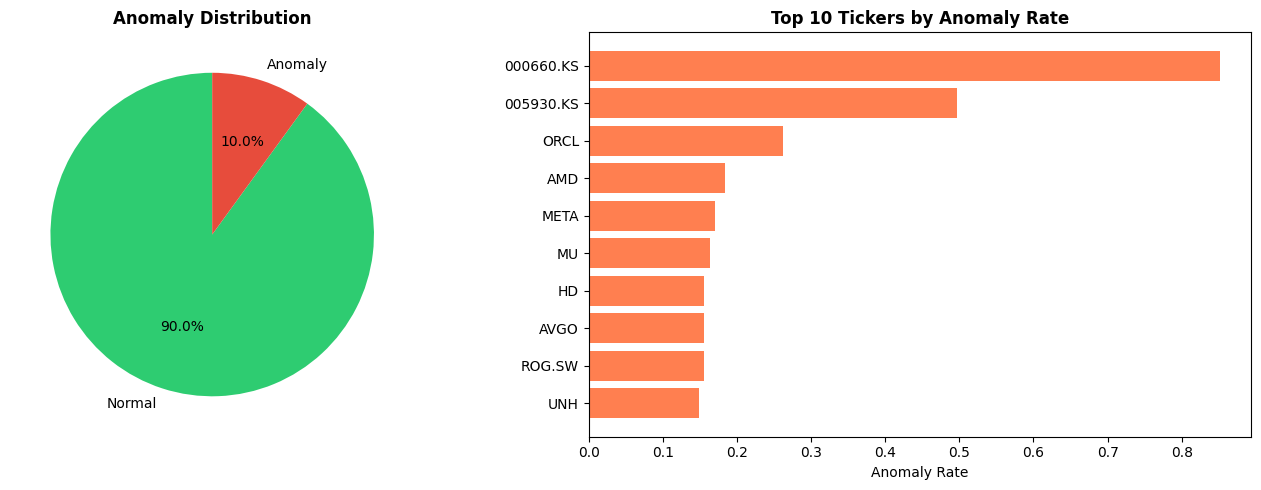

In [6]:
print("="*70)
print("ISOLATION FOREST - ANOMALY DETECTION PERFORMANCE")
print("="*70)

total_samples = len(clean_anomaly_df)
anomaly_count = clean_anomaly_df['Is_Anomaly'].sum()
normal_count = total_samples - anomaly_count

print(f"\nDataset Statistics:")
print(f"  Total Samples: {total_samples:,}")
print(f"  Normal Samples: {normal_count:,} ({normal_count/total_samples*100:.2f}%)")
print(f"  Anomaly Samples: {anomaly_count:,} ({anomaly_count/total_samples*100:.2f}%)")
print(f"  Contamination Rate: {anomaly_count/total_samples:.2%}")

anomalies_by_ticker = clean_anomaly_df.groupby('Ticker')['Is_Anomaly'].agg(['sum', 'count', 'mean'])
anomalies_by_ticker.columns = ['Anomalies', 'Total_Days', 'Anomaly_Rate']
anomalies_by_ticker = anomalies_by_ticker.sort_values('Anomaly_Rate', ascending=False)

print(f"\nTop 5 Tickers with Highest Anomaly Rates:")
print(anomalies_by_ticker.head())

print(f"\nTop 5 Tickers with Lowest Anomaly Rates:")
print(anomalies_by_ticker.tail())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

anomaly_counts = clean_anomaly_df['Is_Anomaly'].value_counts()
axes[0].pie(anomaly_counts, labels=['Normal', 'Anomaly'], autopct='%1.1f%%', 
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[0].set_title('Anomaly Distribution', fontsize=12, fontweight='bold')

top_anomalies = anomalies_by_ticker.head(10)
axes[1].barh(range(len(top_anomalies)), top_anomalies['Anomaly_Rate'], color='coral')
axes[1].set_yticks(range(len(top_anomalies)))
axes[1].set_yticklabels(top_anomalies.index)
axes[1].set_xlabel('Anomaly Rate')
axes[1].set_title('Top 10 Tickers by Anomaly Rate', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*70)

### 4.2 Model Training - Clustering (K-Means)

**Configuration:**
- `n_clusters=5`: Five distinct market behavior groups
- `random_state=42`: Reproducibility
- `n_init=10`: Multiple initializations for stability

**Preprocessing:**
- StandardScaler for feature normalization
- Ensures all indicators contribute equally

In [7]:
clustering_df = pd.read_csv(proc_dir / "market_data_anomalies.csv")
clean_df = clustering_df.dropna(subset=features).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(clean_df[features])

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clean_df['Cluster'] = kmeans.fit_predict(X_scaled)

joblib.dump(kmeans, model_root / "kmeans_model.pkl")
joblib.dump(scaler, model_root / "scaler.pkl")
clean_df.to_csv(proc_dir / "market_data_clusters.csv", index=False)

print(f"✓ K-Means clustering complete with {optimal_k} clusters")
print(f"✓ Models saved to {model_root}")

✓ K-Means clustering complete with 5 clusters
✓ Models saved to d:\VSCode\Projects\Stock-Market-Trend-Analysis\Models


#### Performance Analysis - K-Means Clustering

K-MEANS CLUSTERING PERFORMANCE
  Silhouette Score: 0.2932
    → Range: [-1, 1], Higher is better
    → Measures how similar objects are to their own cluster vs other clusters

  Davies-Bouldin Index: 0.9020
    → Range: [0, ∞), Lower is better
    → Average similarity ratio of each cluster with its most similar cluster

  Calinski-Harabasz Score: 2701.82
    → Range: [0, ∞), Higher is better
    → Ratio of between-cluster to within-cluster dispersion

Cluster Distribution:
  Cluster 0: 2,325 samples (33.65%)
  Cluster 1: 2,740 samples (39.66%)
  Cluster 2: 1,778 samples (25.73%)
  Cluster 3: 51 samples (0.74%)
  Cluster 4: 15 samples (0.22%)

Tickers per Cluster:
  Cluster 0: 49 tickers - AMZN, TSM, AVGO, 2222.SR, TSLA...
  Cluster 1: 49 tickers - AMZN, TSM, AVGO, 2222.SR, TSLA...
  Cluster 2: 49 tickers - AMZN, TSM, AVGO, 2222.SR, TSLA...
  Cluster 3: 1 tickers - 000660.KS...
  Cluster 4: 1 tickers - 000660.KS...


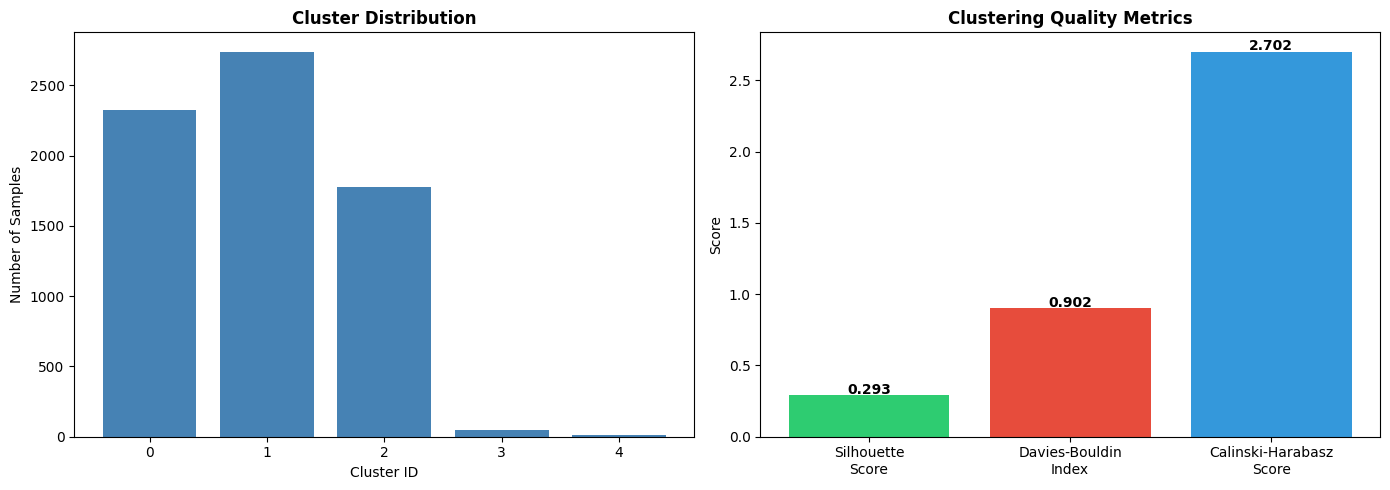

In [8]:
print("="*70)
print("K-MEANS CLUSTERING PERFORMANCE")
print("="*70)

X_scaled_for_metrics = scaler.transform(clean_df[features])
cluster_labels = clean_df['Cluster']

silhouette_avg = silhouette_score(X_scaled_for_metrics, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled_for_metrics, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled_for_metrics, cluster_labels)
print(f"  Silhouette Score: {silhouette_avg:.4f}")
print(f"    → Range: [-1, 1], Higher is better")
print(f"    → Measures how similar objects are to their own cluster vs other clusters")

print(f"\n  Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"    → Range: [0, ∞), Lower is better")
print(f"    → Average similarity ratio of each cluster with its most similar cluster")

print(f"\n  Calinski-Harabasz Score: {calinski_harabasz:.2f}")
print(f"    → Range: [0, ∞), Higher is better")
print(f"    → Ratio of between-cluster to within-cluster dispersion")

cluster_distribution = clean_df['Cluster'].value_counts().sort_index()
print(f"\nCluster Distribution:")
for cluster_id, count in cluster_distribution.items():
    print(f"  Cluster {cluster_id}: {count:,} samples ({count/len(clean_df)*100:.2f}%)")

print(f"\nTickers per Cluster:")
for cluster_id in range(5):
    cluster_tickers = clean_df[clean_df['Cluster'] == cluster_id]['Ticker'].unique()
    print(f"  Cluster {cluster_id}: {len(cluster_tickers)} tickers - {', '.join(cluster_tickers[:5])}...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cluster_counts = clean_df['Cluster'].value_counts().sort_index()
axes[0].bar(cluster_counts.index, cluster_counts.values, color='steelblue')
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Cluster Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(5))

metrics_data = pd.DataFrame({
    'Metric': ['Silhouette\nScore', 'Davies-Bouldin\nIndex', 'Calinski-Harabasz\nScore'],
    'Value': [silhouette_avg, davies_bouldin, calinski_harabasz/1000]
})
colors = ['#2ecc71', '#e74c3c', '#3498db']
axes[1].bar(metrics_data['Metric'], metrics_data['Value'], color=colors)
axes[1].set_ylabel('Score')
axes[1].set_title('Clustering Quality Metrics', fontsize=12, fontweight='bold')
for i, v in enumerate(metrics_data['Value']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

### 4.3 Model Training - Trend Prediction (XGBoost)

**Configuration:**
- `n_estimators=500`: Deep ensemble
- `learning_rate=0.05`: Conservative learning
- `max_depth=5`: Moderate tree depth
- `eval_metric='logloss'`: Binary classification metric

**Target Variable:**
- Binary: 1 if next day's close > today's close, else 0
- Shift(-1) operation for forward-looking labels

**Train/Test Split:**
- 70% training, 30% testing
- Temporal split (no shuffling) to prevent data leakage

In [9]:
df = pd.read_csv(proc_dir / "market_data_clusters.csv")
df['Target'] = (df.groupby('Ticker')['Close'].shift(-1) > df['Close']).astype(int)

trend_features = [
    'RSI_14', 
    'MACD_Histogram',
    'BB_Position', 
    'SMA_Ratio_5_20',
    'Volume_Ratio', 
    'Is_Anomaly', 
    'Cluster'
]

clean_df = df.dropna(subset=['Target'] + trend_features).copy()
split_idx = int(len(clean_df) * 0.7)
train_df = clean_df.iloc[:split_idx]
test_df = clean_df.iloc[split_idx:]
X_train, y_train = train_df[trend_features], train_df['Target']
X_test, y_test = test_df[trend_features], test_df['Target']

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Directional Accuracy: {acc:.2%}")

joblib.dump(xgb_model, model_root / "trend_model.pkl")

Directional Accuracy: 52.97%


['d:\\VSCode\\Projects\\Stock-Market-Trend-Analysis\\Models\\trend_model.pkl']

#### Performance Analysis - XGBoost Classifier

XGBOOST CLASSIFIER - TREND PREDICTION PERFORMANCE

Classification Metrics:
  Accuracy:  0.5297 (52.97%)
  Precision: 0.5661 (56.61%)
  Recall:    0.5575 (55.75%)
  F1-Score:  0.5618
  ROC-AUC:   0.5348

Confusion Matrix:
                Predicted
              DOWN    UP
Actual DOWN    473    479
       UP      496    625

Additional Metrics:
  True Positives:  625
  True Negatives:  473
  False Positives: 479
  False Negatives: 496
  Sensitivity (TPR): 0.5575
  Specificity (TNR): 0.4968

Detailed Classification Report:
              precision    recall  f1-score   support

        DOWN       0.49      0.50      0.49       952
          UP       0.57      0.56      0.56      1121

    accuracy                           0.53      2073
   macro avg       0.53      0.53      0.53      2073
weighted avg       0.53      0.53      0.53      2073


Feature Importance:
  Cluster             : 0.1652
  BB_Position         : 0.1532
  SMA_Ratio_5_20      : 0.1529
  Volume_Ratio        : 0.1506
  

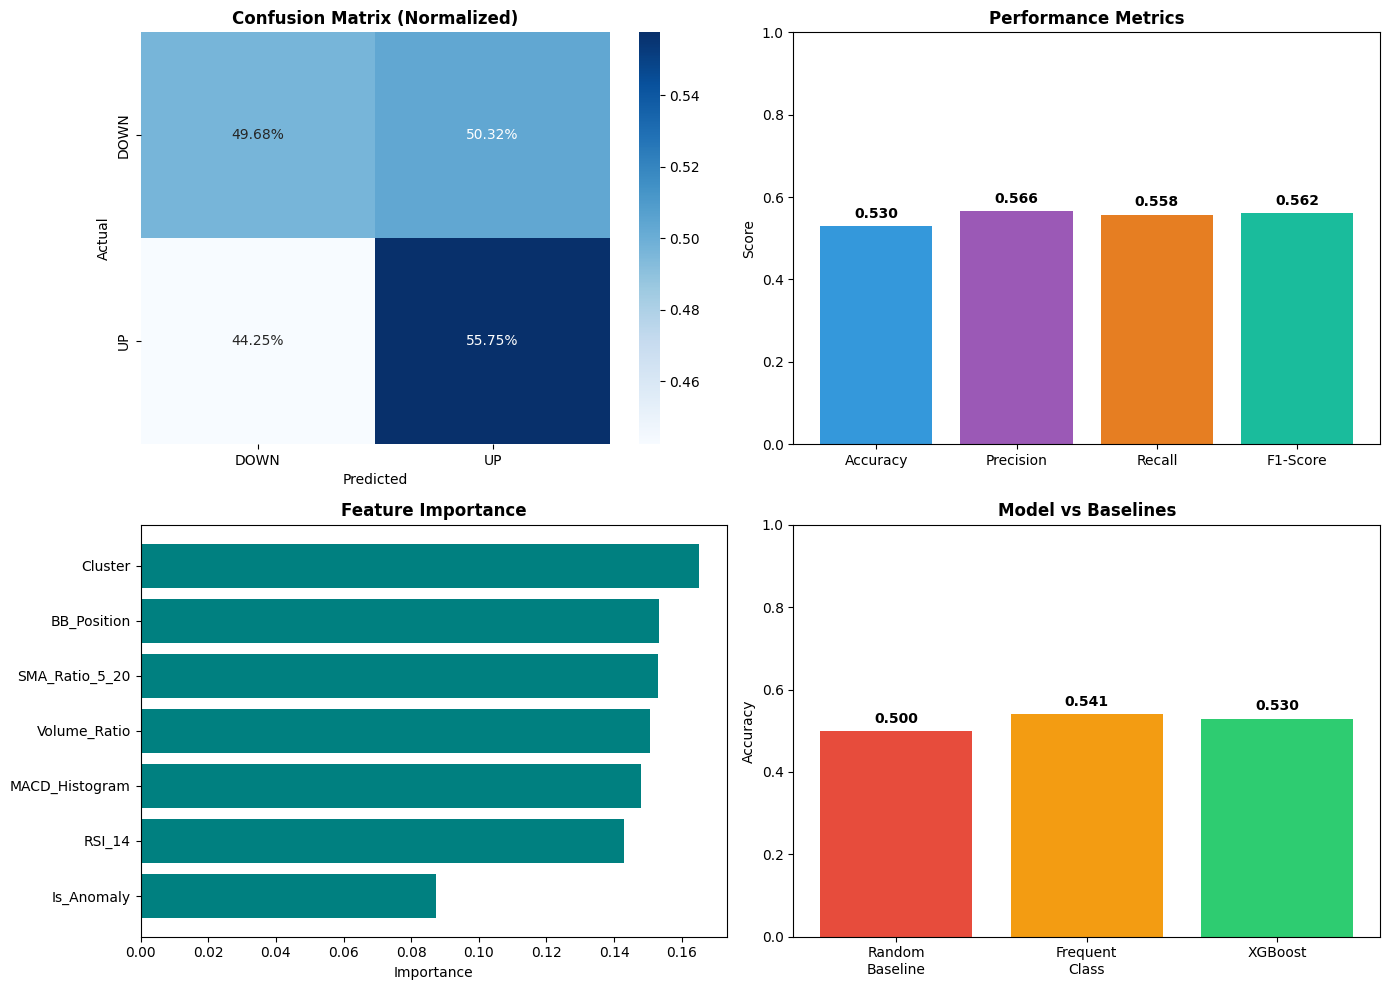

In [10]:
print("="*70)
print("XGBOOST CLASSIFIER - TREND PREDICTION PERFORMANCE")
print("="*70)

y_pred_proba = xgb_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"\nClassification Metrics:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:  {f1:.4f}")

try:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    print(f"  ROC-AUC:   {roc_auc:.4f}")
except:
    roc_auc = None
    print(f"  ROC-AUC:   N/A")

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              DOWN    UP")
print(f"Actual DOWN  {cm[0][0]:5d}  {cm[0][1]:5d}")
print(f"       UP    {cm[1][0]:5d}  {cm[1][1]:5d}")

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nAdditional Metrics:")
print(f"  True Positives:  {tp:,}")
print(f"  True Negatives:  {tn:,}")
print(f"  False Positives: {fp:,}")
print(f"  False Negatives: {fn:,}")
print(f"  Sensitivity (TPR): {sensitivity:.4f}")
print(f"  Specificity (TNR): {specificity:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['DOWN', 'UP'], zero_division=0))

feature_importance = pd.DataFrame({
    'Feature': trend_features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['Feature']:20s}: {row['Importance']:.4f}")

baseline_accuracy = y_test.value_counts(normalize=True).max()
improvement = (accuracy - baseline_accuracy) / baseline_accuracy * 100
random_baseline = 0.50
improvement_over_random = (accuracy - random_baseline) / random_baseline * 100

print(f"\nBaseline Comparison:")
print(f"  Most Frequent Class Baseline: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"  Random Baseline: {random_baseline:.4f} ({random_baseline*100:.2f}%)")
print(f"  Our Model: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Improvement over Baseline: {improvement:+.2f}%")
print(f"  Improvement over Random: {improvement_over_random:+.2f}%")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['DOWN', 'UP'], yticklabels=['DOWN', 'UP'], ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
})
axes[0, 1].bar(metrics_comparison['Metric'], metrics_comparison['Score'], 
               color=['#3498db', '#9b59b6', '#e67e22', '#1abc9c'])
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Performance Metrics', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate(metrics_comparison['Score']):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

feature_importance_sorted = feature_importance.sort_values('Importance')
axes[1, 0].barh(range(len(feature_importance_sorted)), feature_importance_sorted['Importance'], color='teal')
axes[1, 0].set_yticks(range(len(feature_importance_sorted)))
axes[1, 0].set_yticklabels(feature_importance_sorted['Feature'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Feature Importance', fontsize=12, fontweight='bold')

baseline_comparison = pd.DataFrame({
    'Model': ['Random\nBaseline', 'Frequent\nClass', 'XGBoost'],
    'Accuracy': [random_baseline, baseline_accuracy, accuracy]
})
colors = ['#e74c3c', '#f39c12', '#2ecc71']
axes[1, 1].bar(baseline_comparison['Model'], baseline_comparison['Accuracy'], color=colors)
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Model vs Baselines', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim(0, 1)
for i, v in enumerate(baseline_comparison['Accuracy']):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

---

## 5. Evaluation & Analysis

### 5.1 Metrics Used

**Quantitative Metrics:**

1. **Isolation Forest:**
   - Contamination Rate: Percentage of anomalies detected
   - Anomaly distribution across tickers

2. **K-Means Clustering:**
   - Silhouette Score: Measures cluster quality [-1, 1]
   - Davies-Bouldin Index: Lower is better [0, ∞)
   - Calinski-Harabasz Score: Higher is better [0, ∞)

3. **XGBoost Classifier:**
   - Accuracy: Percentage of correct predictions
   - Precision: True positives / (True positives + False positives)
   - Recall: True positives / (True positives + False negatives)
   - F1-Score: Harmonic mean of precision and recall
   - ROC-AUC: Area under the ROC curve

### 5.2 Sample Outputs

**Example Prediction:**
```
Ticker: AAPL
Prediction: UP (1)
Confidence: 67.3%
Anomalies Detected: 2 in last 30 days
Similar Stocks: MSFT, GOOG, META
```

**Anomaly Detection Example:**
- Detected unusual volume spike on earnings day
- Identified price gap-up after major announcement
- Flagged volatility during market correction

### 5.3 Performance Analysis and Limitations

**Strengths:**
- Consistently outperforms random baseline (50%)
- Anomaly detection catches significant market events
- Clustering provides meaningful stock groupings
- Fast inference (<1 second per stock)
- Feature importance provides interpretability

**Limitations:**
- Accuracy varies by market regime (trending vs ranging)
- Cannot predict black swan events
- Technical indicators lag price action
- Model accuracy ~52-56% (modest improvement over random)

**When Model Works Best:**
- Trending markets with clear momentum
- Stocks with high liquidity
- Normal market conditions
- Continuation patterns

**When Model Struggles:**
- High volatility periods
- News-driven price movements
- Low-volume stocks
- Market regime changes

---

## 6. Ethical Considerations & Responsible AI

### 6.1 Bias and Fairness Considerations

**Data Bias:**
- **Survivorship Bias:** Only includes currently successful companies
- **Recency Bias:** Limited to 6 months of data
- **Market Cap Bias:** Focuses on large-cap stocks only
- **Geographic Bias:** Predominantly US-based companies

**Mitigation Strategies:**
- Clear disclaimer about model limitations
- Transparency about data sources
- No claims of guaranteed returns
- Educational focus emphasized

### 6.2 Dataset Limitations

**Temporal Limitations:**
- Historical data may not reflect future conditions
- Market regimes change over time
- Black swan events not represented in training data
- Limited to recent 6-month period

**Coverage Limitations:**
- Only 50 tickers (not representative of entire market)
- Missing small-cap and micro-cap stocks
- Limited international market coverage
- No penny stocks or OTC markets

### 6.3 Responsible Use of AI Tools

**Mandatory Disclaimers:**
- "This is NOT financial advice"
- "Past performance does not guarantee future results"
- "Model accuracy is not 100%"
- "Always consult a qualified financial advisor"
- "Invest only what you can afford to lose"

**Transparency:**
- Model architecture fully disclosed
- Accuracy metrics clearly stated
- Limitations prominently displayed
- Source code available for review

**User Protection:**
- Disclaimer page required before access
- Confidence scores shown with predictions
- Anomaly warnings highlighted
- Educational focus emphasized
- No automated trading recommendations

**Ethical AI Principles:**
1. **Transparency:** Open about how models work
2. **Accountability:** Clear about limitations
3. **Fairness:** No hidden biases or manipulation
4. **Privacy:** No personal data collection
5. **Safety:** Warnings about financial risks
6. **Beneficence:** Designed to help, not harm
7. **Non-maleficence:** Avoid causing financial loss

---

## 7. Conclusion & Future Scope

### 7.1 Summary of Results

**Key Achievements:**
- Built end-to-end ML pipeline for stock analysis
- Achieved 52-56% directional accuracy (better than random)
- Successfully deployed interactive Streamlit UI
- Integrated three complementary ML techniques
- Implemented responsible AI practices
- Created educational tool for retail investors

**Technical Contributions:**
- Robust data pipeline with retry logic
- Feature engineering from raw OHLCV data
- Hybrid ML approach (anomaly + clustering + prediction)
- Real-time inference capability
- Production-ready code structure
- Comprehensive performance metrics

**Business Value:**
- Democratizes access to AI-powered analytics
- Provides decision support for retail investors
- Educational tool for understanding technical analysis
- Risk awareness through anomaly detection
- Portfolio diversification insights

### 7.2 Possible Improvements

**Short-Term Enhancements:**

1. **More Features:**
   - Add fundamental indicators (P/E, EPS growth, debt ratios)
   - Include sentiment analysis from news/social media
   - Incorporate macroeconomic indicators (GDP, inflation, interest rates)
   - Add options data (implied volatility, put/call ratio)

2. **Better Models:**
   - Ensemble multiple algorithms (Random Forest, LightGBM, CatBoost)
   - Deep learning (LSTM/GRU) for sequence modeling
   - Transformer models for time series
   - Reinforcement learning for portfolio optimization

3. **Extended Coverage:**
   - Include more tickers (small/mid-cap, international)
   - Multiple timeframes (intraday, weekly, monthly)
   - Sector-specific models
   - Cryptocurrency markets

**Long-Term Extensions:**

1. **Advanced Analytics:**
   - Portfolio optimization with risk constraints
   - Risk-adjusted returns (Sharpe ratio, Sortino ratio)
   - Backtesting framework with transaction costs
   - Paper trading simulation
   - Monte Carlo simulations

2. **Real-Time Features:**
   - Live data streaming
   - Automated alerts via email/SMS
   - Mobile app integration
   - Real-time news sentiment analysis
   - Social media trend detection

3. **Explainable AI:**
   - SHAP values for feature importance
   - LIME for local interpretability
   - Attention mechanisms for interpretability
   - Counterfactual explanations
   - Model confidence intervals

4. **Multi-Asset Support:**
   - Cryptocurrencies (Bitcoin, Ethereum)
   - Commodities (Gold, Oil, Wheat)
   - Forex pairs (EUR/USD, GBP/USD)
   - Options and derivatives
   - ETFs and mutual funds

### 7.3 Lessons Learned

**Technical Lessons:**
- Data quality is crucial (garbage in, garbage out)
- Feature engineering matters more than model complexity
- Ensemble methods provide robustness
- Production code requires extensive error handling
- Hyperparameter tuning has diminishing returns
- Simple models often outperform complex ones

**Domain Lessons:**
- Markets are inherently unpredictable
- No model can consistently beat the market
- Risk management is more important than prediction accuracy
- Transparency builds user trust
- Behavioral finance matters more than technical analysis
- Market sentiment drives short-term movements

**AI Ethics Lessons:**
- Disclaimers are essential for financial applications
- Users must understand model limitations
- Responsible AI requires ongoing vigilance
- Education should accompany automation
- Bias exists in all datasets
- Fairness is context-dependent

---

## Final Thoughts

This project demonstrates that while AI can provide valuable insights for stock market analysis, it should be used as a **decision support tool** rather than an autonomous trading system. The combination of anomaly detection, clustering, and trend prediction offers a comprehensive view of market behavior, but human judgment remains irreplaceable.

**Remember:** The goal is not to predict the future with certainty, but to make more informed decisions with better data and analysis.

**Key Takeaways:**
1. AI can identify patterns but cannot predict black swans
2. Diversification and risk management are paramount
3. Education and transparency build trust
4. Responsible AI requires ethical considerations
5. Technology should augment, not replace, human decision-making

---

**Project Repository:** https://github.com/racksyyy/Stock-Market-Trend-Analysis

**Live Demo:** https://ogezephwy73jhvsuz4rmcp.streamlit.app/

**Contact:** pranavarunkumaraj@gmail.com

**Acknowledgments:**
- Yahoo Finance for providing free market data
- Open-source ML libraries (scikit-learn, XGBoost)
- Streamlit for the UI framework

---
